# Scenario Theta

In [6]:
import pystorms
import pandas as pd

In [2]:
env = pystorms.scenarios.theta()
done = False

In [3]:
while not done:
    done = env.step()

In [5]:
env.data_log.keys()

dict_keys(['performance_measure', 'flow', 'flooding'])

In [7]:
flows = pd.DataFrame.from_dict(env.data_log['flow'])

<AxesSubplot:>

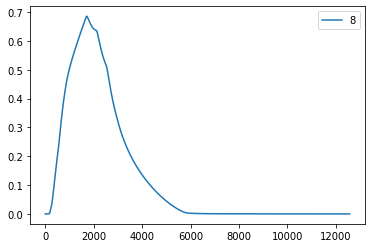

In [8]:
flows.plot()